# Measure performance of WaterZ on GT

In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib widget
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, IntSlider, Layout, interact_manual, fixed
import ipywidgets as widgets
from IPython.display import display
from tqdm import tqdm
from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
lbl_cmap = random_label_cmap()
from stardist.matching import matching, matching_dataset
from trackers import *

## 0. Load Data

In [17]:
import h5py

#path = '../../../data/fate-predict-datasets/Alice/small-alice-tracked-loop/GT/'
path = 'data/GT/'
f = h5py.File(path+'GT_TrackID.h5','r+') # Track file
track = f['image'][:]
f.close()

f = h5py.File(path+'Plantseg_T29-39.h5','r+') # PlantSeg file
plantseg = f['image'][:] # PlantSeg file
f.close()

f = h5py.File(path+'C1mem_T29-39.h5','r+') # PlantSeg file
raw = f['image'][:] # PlantSeg file
f.close()

## 1. Tune WaterZ t param

In [21]:
#image = plantseg[0, 10:30, 50:150, 50:150] # Test on a single slice
#groundtruth = track[0, 10:30, 50:150, 50:150]

image = plantseg[0] # Timestep 0
groundtruth = track[0]
raw = raw[0]

In [7]:
import napari
viewer = napari.Viewer()
viewer.add_image(image, name='PlantSeg')
viewer.add_labels(groundtruth, name='Tracked Fragments')

<Labels layer 'Tracked Fragments' at 0x17ca94550>

### Precision/Recall IoU Threshold=0.8

In [14]:
results = []
for i in np.arange(0, 1.05, 0.05):
    _wz = get_fragments(image.copy(), i)
    
    metrics = matching_dataset([groundtruth], [_wz], thresh=0.8, show_progress=False)._asdict()
    
    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1']
    tp = metrics['tp']
    fp = metrics['fp']
    fn = metrics['fn']

    results.append({'tp': tp, 'fp': fp, 'fn': fn, 'precision':precision, 'recall': recall, 'f1': f1, 't':i})

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.0129592
threshold exceeded
merged 0 edges
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0.05
computing initial scores
merging until 0.05
min edge score 0.0129592
threshold exceeded
merged 3 edges
extracting segmentation
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0

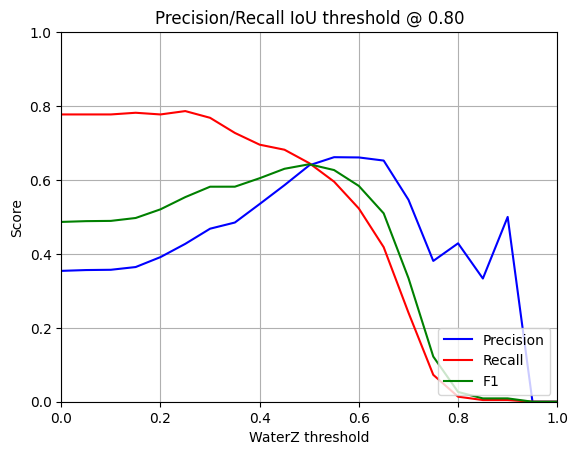

In [21]:
fig = plt.figure()
plt.plot([i['t'] for i in results], [i['precision'] for i in results], 'b', label = 'Precision')
plt.plot([i['t'] for i in results], [i['recall'] for i in results], 'r', label = 'Recall')
plt.plot([i['t'] for i in results], [i['f1'] for i in results], 'g', label = 'F1')

plt.title('Precision/Recall IoU threshold @ 0.80')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('Score')
plt.xlabel('WaterZ threshold')
plt.savefig('exp1.1_tune_waterz_080.png')
plt.show()

### Precision/Recall IoU Threshold=0.95

In [16]:
results2 = []
for i in np.arange(0, 1.05, 0.05):
    _wz = get_fragments(image.copy(), i)
    
    metrics = matching_dataset([groundtruth], [_wz], thresh=0.95, show_progress=False)._asdict()
    
    precision = metrics['precision']
    recall = metrics['recall']
    f1 = metrics['f1']
    tp = metrics['tp']
    fp = metrics['fp']
    fn = metrics['fn']

    results2.append({'tp': tp, 'fp': fp, 'fn': fn, 'precision':precision, 'recall': recall, 'f1': f1, 't':i})

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0
computing initial scores
merging until 0
min edge score 0.0129592
threshold exceeded
merged 0 edges
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0.05
computing initial scores
merging until 0.05
min edge score 0.0129592
threshold exceeded
merged 3 edges
extracting segmentation
Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0

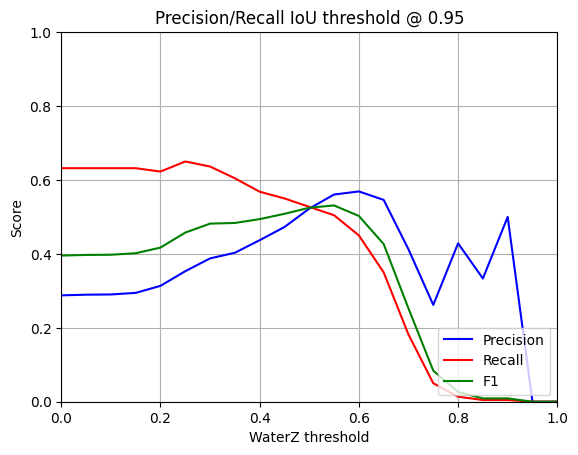

In [20]:
fig = plt.figure()
plt.plot([i['t'] for i in results2], [i['precision'] for i in results2], 'b', label = 'Precision')
plt.plot([i['t'] for i in results2], [i['recall'] for i in results2], 'r', label = 'Recall')
plt.plot([i['t'] for i in results2], [i['f1'] for i in results2], 'g', label = 'F1')

plt.title('Precision/Recall IoU threshold @ 0.95')
plt.legend(loc = 'lower right')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.grid()
plt.ylabel('Score')
plt.xlabel('WaterZ threshold')
plt.savefig('exp1.2_tune_waterz_095.png')
plt.show()

## Plot IoU Threshold (ROC Curve) for WaterZ t=0.55 (Best)

### Visualize prediction

In [7]:
Y_pred = get_fragments(image.copy(), 0.55)

Re-using already compiled waterz version
Preparing segmentation volume...
counting regions and sizes...
creating region graph for 484 nodes
creating statistics provider
extracting region graph...
Region graph number of edges: 2159
merging until threshold 0.55
computing initial scores
merging until 0.55
min edge score 0.0129592
threshold exceeded
merged 285 edges
extracting segmentation


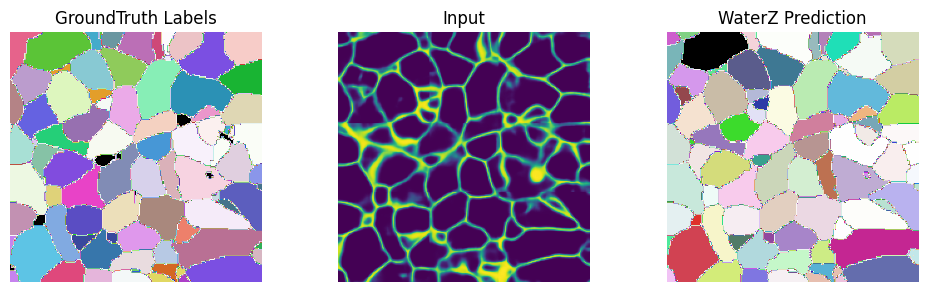

In [32]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 3


fig.add_subplot(rows, columns, 1)
plt.imshow(groundtruth[10], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth Labels')

fig.add_subplot(rows, columns, 2)
plt.imshow(image[10])
plt.axis('off')
plt.title('Input')

fig.add_subplot(rows, columns, 3)
plt.imshow(Y_pred[10], cmap=lbl_cmap)
plt.axis('off')
plt.title('WaterZ Prediction')

plt.savefig('exp1.3_waterz_pred.png')

plt.tight_layout()
plt.show()

### Performance

In [8]:
from stardist.matching import matching, matching_dataset

taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset([groundtruth], [Y_pred], thresh=t, show_progress=False) for t in tqdm(taus)]



  0%|                                                                                                                                                   | 0/9 [00:27<?, ?it/s]


 11%|███████████████▍                                                                                                                           | 1/9 [00:00<00:04,  1.80it/s]

 44%|█████████████████████████████████████████████████████████████▊                                                                             | 4/9 [00:00<00:00,  7.04it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00,  9.68it/s]


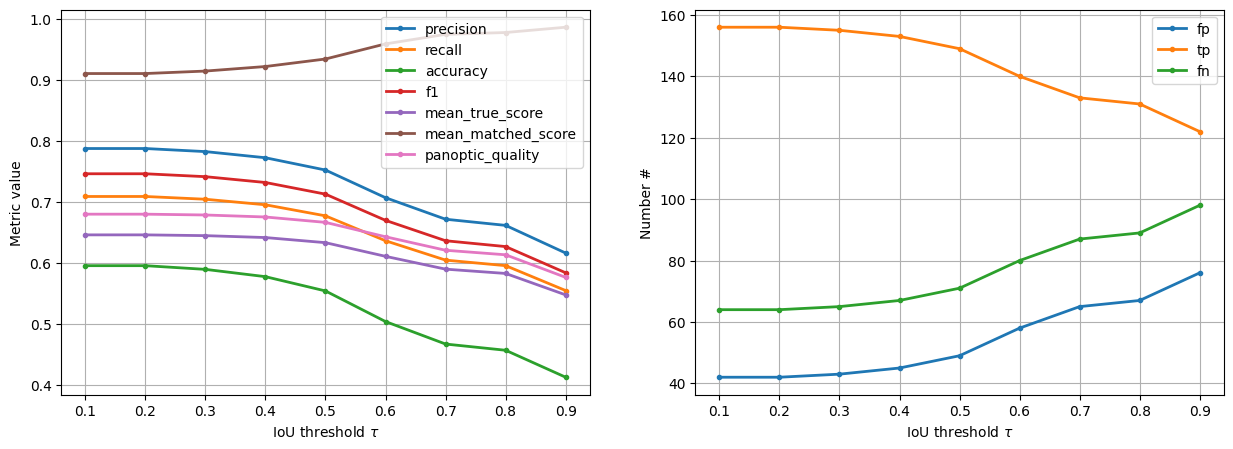

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend()

plt.savefig('exp1.3_iou_pr_waterz_055.png')

In [10]:
stats1 = stats
print('%.3f & %.3f & %.3f & %.3f & %.3f & %.3f\\\\' % (stats1[taus.index(0.5)].f1, stats1[taus.index(0.5)].accuracy, stats1[taus.index(0.7)].f1, stats1[taus.index(0.7)].accuracy, stats1[taus.index(0.9)].f1, stats1[taus.index(0.9)].accuracy))

0.713 & 0.554 & 0.636 & 0.467 & 0.584 & 0.412\\


In [13]:
# Pickle predictions
import pickle
pickle.dump({
    'taus': taus,
    'stats': [s._asdict() for s in stats]
}, open( '1_waterz_stats.pkl', 'wb' ))

In [41]:
t_f.close()
p_f.close()

## Measure background pixels in GT

In [7]:
bg_c = np.sum(track == 0)
cell_c =np.sum(track > 0)
bg_c/(bg_c+cell_c)*100

2.040016618808705

# Oversegmentation comparison

In [8]:
import mahotas as mh
inputimage = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
minima = mh.regmin(inputimage)
markers, nr_markers = mh.label(minima)
fragments = mh.cwatershed(inputimage, markers, return_lines=False)
fragments = fragments.astype('uint64')

In [20]:
raw.shape

(11, 43, 200, 201)

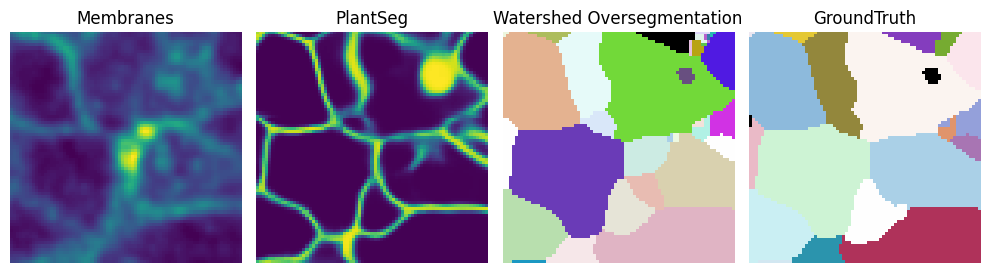

In [23]:
fig = plt.figure(figsize=(10, 3))

rows = 1
columns = 4


fig.add_subplot(rows, columns, 1)
plt.imshow(raw[10, 100:175, 100:175])
plt.axis('off')
plt.title('Membranes')

fig.add_subplot(rows, columns, 2)
plt.imshow(image[10, 100:175, 100:175])
plt.axis('off')
plt.title('PlantSeg')

fig.add_subplot(rows, columns, 3)
plt.imshow(fragments[10, 100:175, 100:175], cmap=lbl_cmap)
plt.axis('off')
plt.title('Watershed Oversegmentation')

fig.add_subplot(rows, columns, 4)
plt.imshow(groundtruth[10, 100:175, 100:175], cmap=lbl_cmap)
plt.axis('off')
plt.title('GroundTruth')

plt.savefig('watershed_oversegmented.png')

plt.tight_layout()
plt.show()